# Neural Net Inference and Perturbations


Part of this code is based on Alexander Madry's lab robustness applications toolkit and Google Deepdream. You can check more in https://github.com/MadryLab
and https://distill.pub/2017/feature-visualization/


**Note:** To speed up the execution of the experiments we recommend using GPU acceleration. If you run this in Colab, simply do:

Runtime > Change Runtime type > Hardware accelerator > Gpu

In [1]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torchvision.models as models
import cv2
import torchvision.transforms as transforms
cuda_available = torch.cuda.is_available()
from model import BaselineNet, TrafficSignNet, Stn
from data import get_train_loaders, preprocess

Download the test image and models

In [4]:
import pickle
PATH = "./"
datasets_path = "./data/"
models_path = "./models/"

training_file = datasets_path + 'train.pickle'
validation_file= datasets_path + 'valid.pickle'
testing_file = datasets_path + 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Inference in a neural network

In this exercise, you will be playing with a convolutional network to classify images into semantic labels. You will be working with ResNet50, a variant of the residual convolutional network architecture. We will be testing the network to classify images into the 1000 imagenet categories.

### Load imagenet class names


In [5]:
# Let's get some dimensions
print("Features shape: ", X_train.shape)
print("Leatures shape: ", y_train.shape)

Features shape:  (35288, 128, 128, 3)
Leatures shape:  (35288,)


In [6]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of validation examples = 3921
Number of testing examples = 12630
Image data shape = (128, 128, 3)
Number of classes = 43


In [8]:
# Load sign names file
import pandas as pd
sign_names = pd.read_csv("./signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [10]:
imagenet_classes_short = sign_names.SignName
for it, class_name in enumerate(imagenet_classes_short):
    if it == 3:
        print('...')
    elif it < 4 or it > 40:
        print('{}. {}'.format(it, class_name))

0. Speed limit (20km/h)
1. Speed limit (30km/h)
2. Speed limit (50km/h)
...
41. End of no passing
42. End of no passing by vechiles over 3.5 metric tons


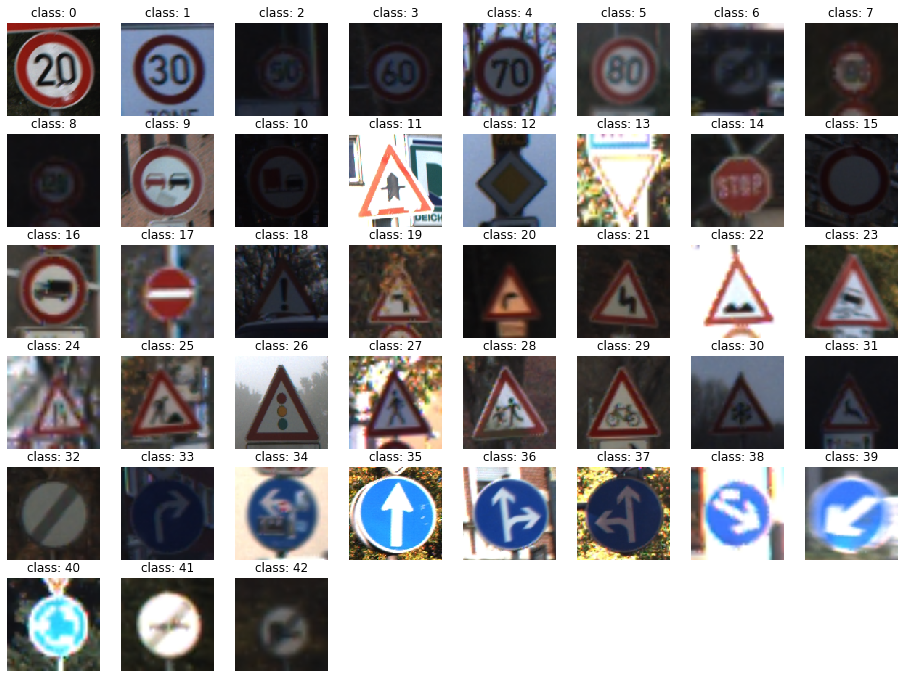

In [15]:
plt.figure(figsize = (16,16))
for c in range(n_classes):
    i = np.random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])
    plt.imsave(PATH+'/examples/class: {}.png'.format(c), X_train[i])

## Running a randomly initialized network

We will start by using a randomly initalized network to perform classification

In [16]:
device = 'cuda' if cuda_available else 'cpu'
model = BaselineNet()
model.load_state_dict(torch.load(models_path+'128baseline_model.pt', map_location = device))
# We set it in eval, so that batch normalization layers are not updated
model.eval();
if cuda_available:
    model.cuda()

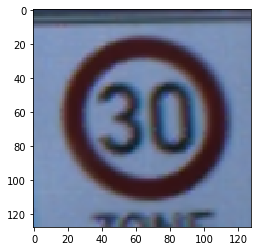

In [17]:
# Load the image we will be playing with
img = cv2.imread(PATH+'/examples/class: 1.png')
plt.imshow(img[:, :, ::-1])


### Preparing the image for inference

In [19]:
# In order to run the image through a model. We need to prepare it first
# This includes:
# 1. Resizing the image to an appropiate size for the network
# 2. Convert the image to a tensor - this will set the image in the 0-1 range
#    and change the channel/dimensions order
# 3. Normalize the image
# 4. Put the image in a batch. In our case we will use a single element batch.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def prepare_image(image_cv2, do_normalize=True):
      # Resize
      img = cv2.resize(image_cv2, (128, 128))
      img = img[:, :, ::-1].copy()
      # Convert to tensor
      tensor_img = transforms.functional.to_tensor(img)

      # Possibly normalize
      if do_normalize:
        tensor_img = normalize(tensor_img)
      # Put image in a batch
      batch_tensor_img = torch.unsqueeze(tensor_img, 0)

      # Put the image in the gpu
      if cuda_available:
        batch_tensor_img = batch_tensor_img.cuda()
      return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
      std_arr = torch.tensor(std)[:, None, None]
      mean_arr = torch.tensor(mean)[:, None, None]
      def func(img):
        img = img.clone()
        img *= std_arr
        img += mean_arr
        return img
      return func
unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
      tensor_img = tensor_img.cpu()
      if do_normalize:
         tensor_img = unnormalize(tensor_img)
      img = transforms.functional.to_pil_image((tensor_img.data))
      return img



### Running the image

This architecture outputs a vector of 1000 elements, that correspond to the class logits: each of the class probabilities before doing a softmax.

In [20]:
# Prepare the image
batch_normalized_img = prepare_image(img)
# Run it through the network
output = model(batch_normalized_img)

Let's visualize the top classes

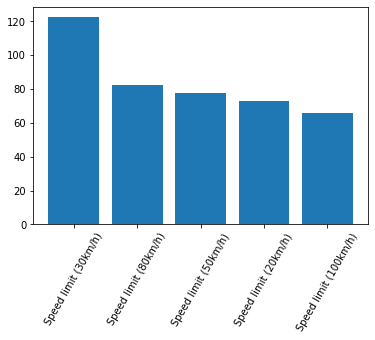

In [21]:
def plot_top_classes(values, top_k=5):
      sorted_classes = np.argsort(-values)
      class_ids = sorted_classes[:top_k]
      class_names = [imagenet_classes_short[it] for it in list(class_ids)]
      class_values = values[class_ids]
      plt.bar(class_names, class_values)
      plt.xticks(rotation=60)


plot_top_classes(output[0,:].data.cpu().numpy())

The top predictions seem to have much more sense now. But it is not clear what the scalar in the plot means. Complete the code below to normalize the logits to the log of the percentage, using the torch.nn.functional.log_softmax function.

/Users/Ann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


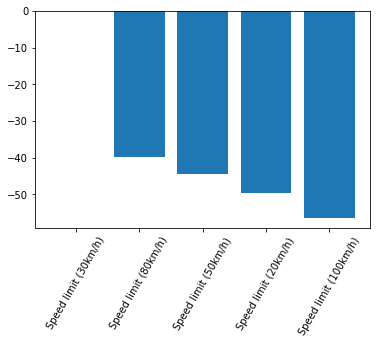

In [23]:
output = model(batch_normalized_img.to(device))
output_probs = torch.nn.functional.log_softmax(output)# YOUR CODE GOES HERE
plot_top_classes(output_probs[0,:].data.cpu().numpy())

# Deep Dreaming

When training a neural network, we use backpropagation to obtain the gradient of the loss with respect to the network parameters, and use it to update the the parameters that minimize the loss. 

We can also use backpropagation to obtain the gradient of the loss with respect to the input image, given the network parameters. If we update the image according to that gradient, we can generate images that maximize certain activations, or minimize the loss. We will look into it here.

### Step class

We will use the following class to generate our image. This class will take a tensor x corresponding to the image a g corresponding to the gradient and will update x according to g. To ensure that the updated image lies in a reasonable manifold, we will also allow for a projection.

In [24]:
class StepImage():
      def __init__(self, orig_input, step_size=2, is_normalized=True, 
                   renorm=True, eps=30, norm_update='l2'):
        self.orig_input = orig_input
        if is_normalized:
          mean=[0.485, 0.456, 0.406]
          std= [0.229, 0.224, 0.225]
        else:
          mean=[0., 0., 0.]
          std= [1., 1., 1.]

        is_cuda = orig_input.is_cuda
        self.mean = torch.tensor(mean)[:, None, None]
        self.std = torch.tensor(std)[:, None, None]
        if is_cuda:
          self.mean = self.mean.cuda()
          self.std = self.std.cuda()
        self.eps = eps
        self.renorm = renorm
        self.step_size = step_size
        self.norm_update = norm_update
    
      def project(self, x):
        """
        """
        diff = x - self.orig_input
        if self.renorm:
          diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
        val_projected = self.orig_input + diff

        val_projected *= self.std
        val_projected += self.mean
        val_clamped = torch.clamp(val_projected, 0, 1)
        val_clamped -= self.mean
        val_clamped /= self.std
        return val_clamped
  
      def step(self, x, g):
        step_size = self.step_size
        # Scale g so that each element of the batch is at least norm 1
        if self.norm_update == 'l2':
              l = len(x.shape) - 1
              g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
        else:
              g_norm = torch.torch.abs(g).mean()
        scaled_g = g / (g_norm + 1e-10)
        stepped = x + scaled_g * step_size
        projected = self.project(stepped)
        return projected

We will now update the image to maximize a new class (id 76 - Tarantula).

In [26]:
img = cv2.imread(PATH+'/examples/class: 1.png')
starting_image = prepare_image(img)

# This allows to backpropagate the image
batch_tensor = starting_image.clone().requires_grad_(True)

# This updates the image according to some gradient
step = StepImage(starting_image, step_size=0.05, 
                 is_normalized=True, renorm=False, norm_update='abs')
for _ in tqdm(range(10)):
  # YOUR CODE GOES HERE. You should:
  # 1. Run the model with batch_tensor
  # 2. Describe the loss or the objective you want to maximize
  # 3. Compute the gradient of the objective with respect to the image
  # using torch.autograd.grad
  
      inputs = batch_tensor.to(device)
      objective = torch.nn.functional.log_softmax(model.forward(inputs),1)[0,0]


      ###
      gradient, = torch.autograd.grad(objective, inputs)

      batch_tensor = step.step(batch_tensor, gradient)
  


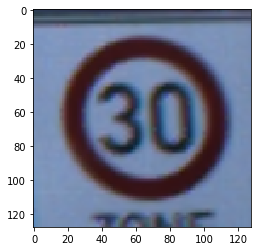

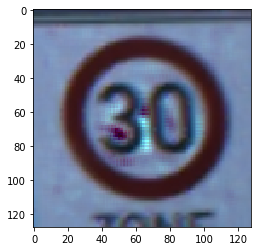

In [27]:
image = obtain_image(starting_image[0, :], do_normalize=True)
plt.imshow(image)
image = obtain_image(batch_tensor[0, :], do_normalize=True)
plt.figure()
plt.imshow(image)

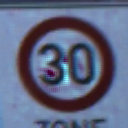

In [29]:
image

Check out the top predictions for this image

/Users/Ann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


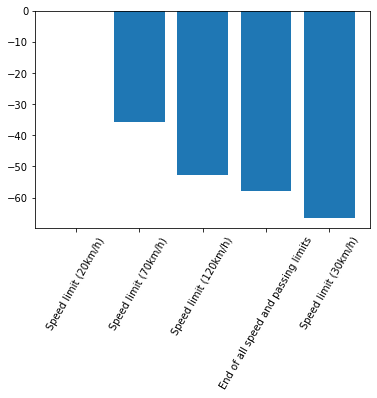

In [28]:
output = model(batch_tensor)
output_probs = torch.nn.functional.log_softmax(output)# CODE HERE
plot_top_classes(output_probs[0,:].data.cpu().numpy())